In [ ]:
%load_ext autoreload
%autoreload 2
!pip install rdd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdd import rdd
import statsmodels.formula.api as smf 

import whynot as wn
from whynot import DynamicsExperiment, parameter
from whynot.simulators import world2

# Regression Discontinuity Design
In this notebook, we explore how one might perform an experiment and analyze the data collected using regression discontinuity design (RDD). Typically an RDD is applied when the assignment of treatment $T$ is determined by whether an observed covariate $X$ lies on one side of a fixed threshold value $c$. Under the assumption that the outcome variable $Y$ varies continuously with $X$ for treated (or untreated) individuals, one can estimate the treatment effect $\mathbb{E}[Y \mid do(T=1)] - \mathbb{E}[Y \mid do(T=0)]$ by performing regressions on both sides of the threshold.

## Simulator: [World2](https://whynot-docs.readthedocs-hosted.com/en/latest/simulators.html#world2-simulator)
We use the World2 simulator. In this experiment, we set up the following: $X$ is the initial population level (Year 1900), $Y$ is the population at the end of the simulation (Year 2000), and the treatment is lowering the pollution factor from 1 to 0.75 in Year 1901. The threshold for assigning treatment is $c = 2e8$. In other words, the pollution factor is lowered $(T=1)$ if and only if the initial pollution level is higher than $c$.

Running the following commands shows us the default values of the simulator parameters.

In [10]:
wn.world2.State()

State(population=1650000000.0, natural_resources=900000000000.0, capital_investment=400000000.0, pollution=200000000.0, capital_investment_in_agriculture=0.2, initial_natural_resources=900000000000.0)

In [11]:
wn.world2.Config()

Config(birth_rate=0.04, death_rate=0.028, effective_capital_investment_ratio=1.0, natural_resources_usage=1.0, land_area=135000000.0, population_density=26.5, food_coefficient=1.0, food_normal=1.0, capital_investment_agriculture=0.3, capital_investment_generation=0.05, capital_investment_discard=0.025, pollution_standard=3600000000.0, pollution=1.0, intervention_time=1970, capital_investment_in_agriculture_frac_adj_time=15.0, quality_of_life_standard=1.0, start_time=1900, end_time=2100, delta_t=0.2, rtol=1e-06, atol=1e-06)

## Constructing a regression discontinuity experiment

We construct a causal experiment by specifying the **initial state distribution**, the **treatment rule** (in this case a threshold), the **observed covariates**, and **the outcome** to measure.

In [16]:
def sample_initial_states(rng):
    """Sample an initial world2 state by randomly perturbing the default initial state."""
    state = world2.State()
    state.population *= rng.uniform(0.75, 2)
    state.natural_resources *= rng.uniform(0.25, 10.)
    state.capital_investment *= rng.uniform(0.5, 2.0)
    state.pollution *= rng.uniform(0.2, 2.)
    state.capital_investment_in_agriculture *= rng.uniform(0.5, 1.5)
    return state

@parameter(name="treatment_threshold", default=2e8,
           description="Threshold for treatment")
def threshold_treatment_propensity(untreated_run, treatment_threshold):
    """Assign treatment with probability 1 if initial pollution is above threshold, and 0 otherwise."""
    if untreated_run.initial_state.pollution >= treatment_threshold:
        return 1.0
    return 0.

In [17]:
# Construct the experiment object
ThresholdTreatment = DynamicsExperiment(
    name="world2_threshold_treatment",
    description="Experiment with threshold treatment on World 2.",
    simulator=world2,
    simulator_config=world2.Config(end_time=2000),
    intervention=world2.Intervention(time=1901, pollution=0.75),  
    state_sampler=sample_initial_states,
    propensity_scorer=threshold_treatment_propensity,
    outcome_extractor=lambda run: run[2000].population, 
    covariate_builder=lambda run: run.initial_state.pollution)

## Generating data

We instantiate the experiment and collect 1000 independent samples.

In [ ]:
dataset = ThresholdTreatment.run(num_samples=1000, seed=1234)

In [61]:
(X, W, Y) = dataset.covariates, dataset.treatments, dataset.outcomes

For convenience we scale down the values for population and pollution.

In [71]:
data = pd.DataFrame({'y':Y / 1e8, 'x': X.flatten() / 1e8})
threshold = 2.0

## Visualizing the data
Let's take a look at the data. Visually, the population numbers are higher to the left of the threshold $c$.

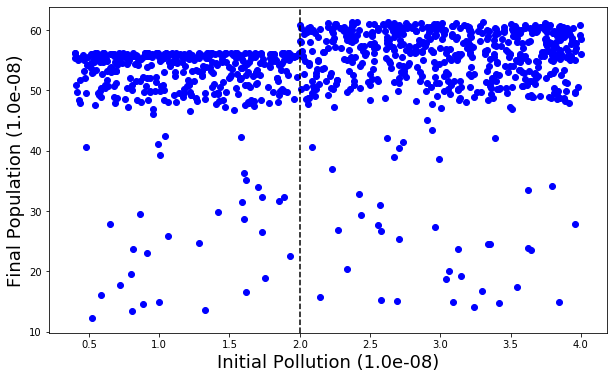

In [72]:
plt.figure(figsize=(10, 6))
plt.scatter(data.x, data.y, color="blue")
plt.xlabel(f"Initial Pollution ({scaling:.1e})", fontsize="18")
plt.ylabel(f"Final Population ({scaling:.1e})", fontsize="18")
plt.axvline(x=threshold, color="black", linestyle="--")
plt.show()
plt.close()

## Running the regression discontinuity analysis

Now, we perform the regression discontinuity analysis. First, we set up the dataframe by creating two new columns: one for the treatment variable $T$ and one for the centered covariate $X$.

In [73]:
data['treat'] = data['x'].map(lambda x: x >= threshold)
data['x_centered'] = data['x'].map(lambda x: x - threshold)

The bandwidth of the RDD is a window around the threshold $c$. We use only the data points inside the window and ignore data points beyond it. We can pick the optimal bandwidth, in this case, using the Imbens-Kalyanamaran optimal bandwidth calculation.

In [83]:
bandwidth_opt = rdd.optimal_bandwidth(data['y'], data['x'], cut=threshold)
print("Optimal bandwidth:", bandwidth_opt)

Optimal bandwidth: 1.128808104144816


We regress $Y$ on $X$ and $T$ by ordinary least squares. We can make two observations: $T$ has a statistically significant effect on $Y$ (there is a positive jump discontinuity at the threshold), and $Y$ decreases with $X$. Both observations corroborate with our intuition about how the World2 model should behave. Lowering the pollution factor increases the future pollution, and higher initial pollution levels decreases the futture pollution.

In [78]:
data_cut = data[(data['x_centered'] >= -bandwidth_opt) & (data['x_centered'] <= bandwidth_opt)]
result = smf.ols(formula = "y ~ x_centered + treat", data = data_cut).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.654
Date:                Thu, 05 Mar 2020   Prob (F-statistic):           0.000197
Time:                        16:56:44   Log-Likelihood:                -2119.5
No. Observations:                 603   AIC:                             4245.
Df Residuals:                     600   BIC:                             4258.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        51.2891      0.761     67.395

## Plot the RDD analysis results

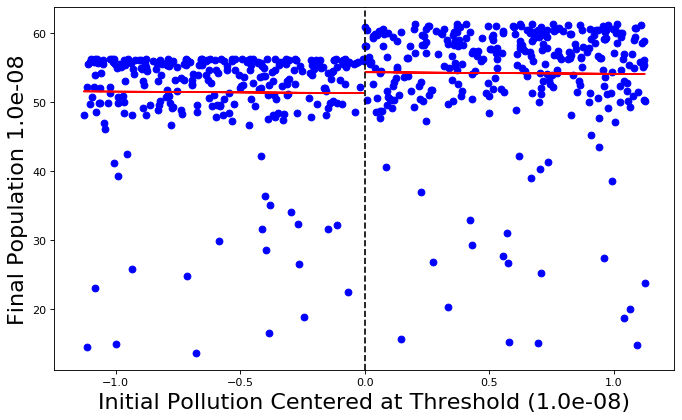

In [80]:
%matplotlib inline
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data_cut.x_centered, data_cut.y, color="blue")

plt.plot(data_cut.x_centered[data_cut.x_centered < 0],
         result.predict()[data_cut.x_centered < 0], '-', color="r")
plt.plot(data_cut.x_centered[data_cut.x_centered >= 0],
         result.predict()[data_cut.x_centered >= 0], '-', color="r")
plt.axvline(x=0,color="black", linestyle="--")
plt.xlabel(f"Initial Pollution Centered at Threshold ({scaling:.1e})", fontsize="20")
plt.ylabel(f"Final Population {scaling:.1e}", fontsize="20");